In [126]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import re
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 
from quantimpy import minkowski as mk

In [127]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [128]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

NOISE_LEVEL = 0.8

NUM_SAMPLES = 64
AVG_PS_OF_NOISE = True ## Averages the power spectrum of added_noise on images

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [130]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [131]:
all_timesteps = torch.tensor(range(diffuser.diffmodel.sde.N))
all_noise_levels = diffuser.diffmodel.sde.noise_level(all_timesteps).reshape(-1)
closest_timestep = torch.argmin(torch.abs(all_noise_levels - NOISE_LEVEL))
closest_timestep, diffuser.diffmodel.sde.noise_level(closest_timestep).reshape(-1)

(tensor(217, device='cuda:0'), tensor([0.8000], device='cuda:0'))

In [132]:
theta_fid = torch.tensor([[70, 0.0321]]).to(device)
#theta = diffuser.diffmodel.ps.sample_theta(1).to(device)
theta = theta_fid
theta[0], theta.shape

(tensor([7.0000e+01, 3.2100e-02], device='cuda:0'), torch.Size([1, 2]))

## Different images of the problem

In [133]:
image = diffuser.test_dataloader.dataset[0].unsqueeze(0).unsqueeze(1).to(device)
image.shape

torch.Size([1, 1, 256, 256])

In [134]:
ps_theta = diffuser.diffmodel.ps(theta) ## You can chose theta close to the mean and see if there is a difference
sqrt_ps_theta = torch.sqrt(ps_theta)

In [135]:
noisy_image, mean_noisy_image, added_noise = diffuser.diffmodel.sde.sampling(image, closest_timestep, sq_ps=sqrt_ps_theta)

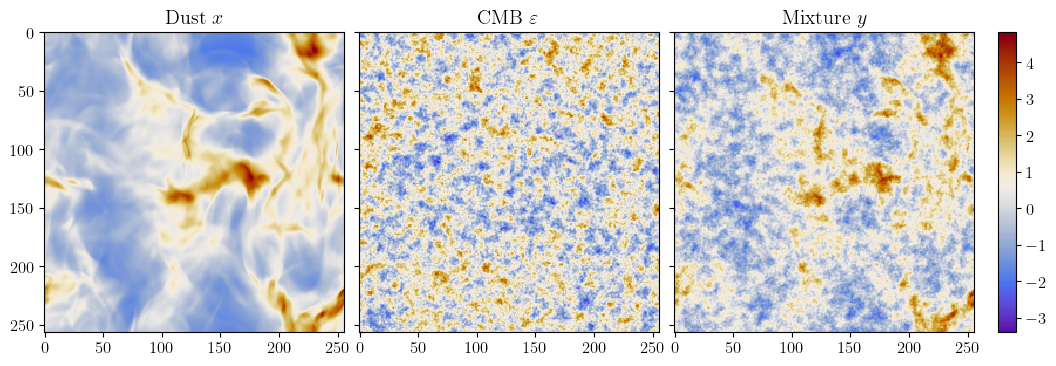

In [136]:
x = image[0, 0].cpu().numpy()
e = added_noise[0, 0].cpu().numpy()
y = noisy_image[0, 0].cpu().numpy()

vmin = np.min([x, e, y])
vmax = np.max([x, e, y])
cmap = 'cmb'

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
im0 = axs[0].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)
im1 = axs[1].imshow(e, cmap=cmap, vmin=vmin, vmax=vmax)
im2 = axs[2].imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('Dust $x$')
axs[1].set_title(r'CMB $\varepsilon$')
axs[2].set_title('Mixture $y$')
fig.colorbar(im0, cax=fig.add_axes([0.92, 0.12, 0.015, 0.75])) # left, bottom, width, height
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_fig:
    fig.savefig('figs/data.pdf', bbox_inches='tight')

## With source separation

In [137]:
noisy_batch = noisy_image.repeat(NUM_SAMPLES, 1, 1, 1)
theta_batch = theta.repeat(NUM_SAMPLES, 1)

noisy_batch.shape

torch.Size([64, 1, 256, 256])

In [138]:
denoised_batch = diffuser.diffmodel.generate_image(NUM_SAMPLES, sample= noisy_batch, thetas = theta_batch, initial_timestep=closest_timestep.item())

  7%|▋         | 16/217 [00:00<00:06, 33.09it/s]

100%|██████████| 217/217 [00:06<00:00, 33.35it/s]


In [139]:
noisy_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, closest_timestep.repeat(NUM_SAMPLES))
estimated_noise = noisy_batch - denoised_batch
estimated_noise = estimated_noise/NOISE_LEVEL
estimated_noise.shape

torch.Size([64, 1, 256, 256])

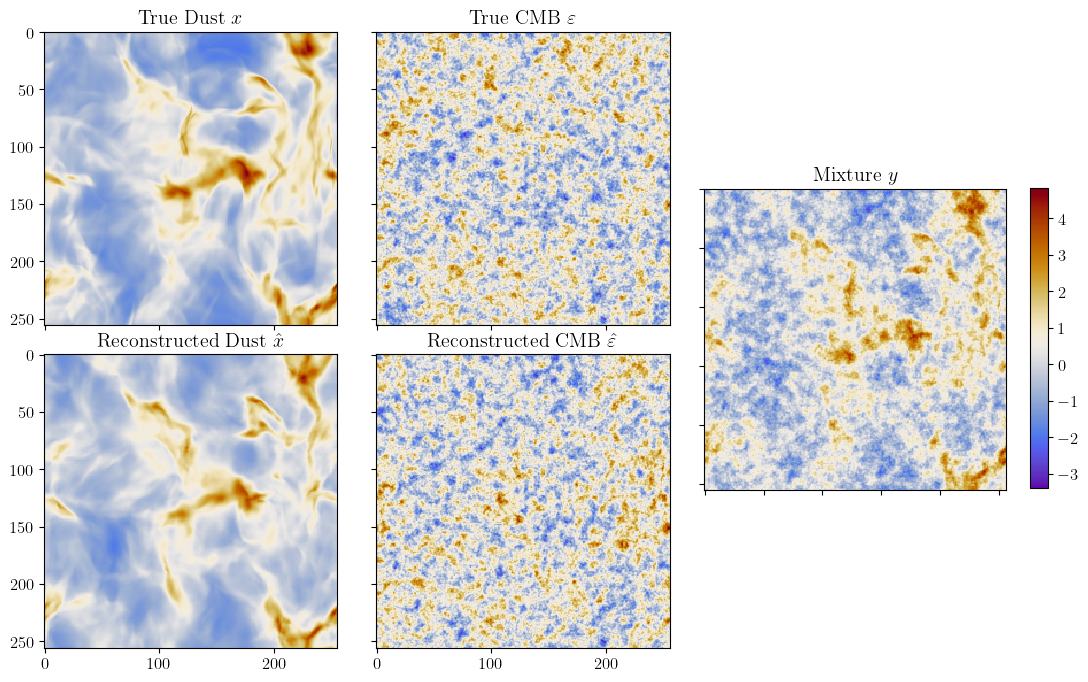

In [140]:
x = image[0, 0].cpu().numpy()
e = added_noise[0, 0].cpu().numpy()
y = noisy_image[0, 0].cpu().numpy()

xh = denoised_batch[0, 0].cpu().numpy()
eh = estimated_noise[0, 0].cpu().numpy()

vmin = np.min([x, e, y])
vmax = np.max([x, e, y])
cmap = 'cmb'

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

gs = axs[0, 2].get_gridspec()

for ax in axs[:, 2]:
    ax.remove()

ax_mixture = fig.add_subplot(gs[:, -1])

im0 = axs[0, 0].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 1].imshow(e, cmap=cmap, vmin=vmin, vmax=vmax)
ax_mixture.imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('True Dust $x$')
axs[0, 1].set_title(r'True CMB $\varepsilon$')
ax_mixture.set_title('Mixture $y$')

# Remove tick labels for ax_mixture
ax_mixture.set_xticklabels([])
ax_mixture.set_yticklabels([])

axs[1, 0].imshow(xh, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 1].imshow(eh, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 0].set_title(r'Reconstructed Dust $\hat{x}$')
axs[1, 1].set_title(r'Reconstructed CMB $\hat{\varepsilon}$')

fig.colorbar(im0, cax=fig.add_axes([0.95, 0.31, 0.015, 0.375])) # left, bottom, width, height
fig.subplots_adjust(right=0.93, wspace=0.1, hspace=0.1)
if save_fig:
    fig.savefig('figs/data_with_sourcesep.pdf', bbox_inches='tight')

## Stats

In [141]:
## Rescale noisy_image

noisy_image = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_image, closest_timestep)

## Rescale the noise back

estimated_noise *= NOISE_LEVEL

## Rescale the nosie 

if not AVG_PS_OF_NOISE:
    added_noise *= NOISE_LEVEL
else:
    _, _, added_noise = diffuser.diffmodel.sde.sampling(image.repeat(NUM_SAMPLES,1,1,1), closest_timestep, sq_ps=sqrt_ps_theta.repeat(NUM_SAMPLES,1,1,1))
    added_noise = added_noise*NOISE_LEVEL

In [142]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##

## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [image, noisy_image, added_noise, denoised_batch, estimated_noise]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [143]:
ps_bins = bins_centers.cpu()
ps_mean_list = [mean[:-1] for mean in mean_list]
ps_std_list = [std[:-1] for std in std_list]

In [144]:
l_image = np.split(image.cpu().numpy(), len(image), axis=0)
l_image = [np.ascontiguousarray(l_image[i][0][0]) for i in range(len(l_image))]

l_noisy_image = np.split(noisy_image.cpu().numpy(), len(noisy_image), axis=0)
l_noisy_image = [np.ascontiguousarray(l_noisy_image[i][0][0]) for i in range(len(l_noisy_image))]

l_added_noise = np.split(added_noise.cpu().numpy(), len(added_noise), axis=0)
l_added_noise = [np.ascontiguousarray(l_added_noise[i][0][0]) for i in range(len(l_added_noise))]

l_denoised_batch = np.split(denoised_batch.cpu().numpy(), len(denoised_batch), axis=0)
l_denoised_batch = [np.ascontiguousarray(l_denoised_batch[i][0][0]) for i in range(len(l_denoised_batch))]

l_estimated_noise = np.split(estimated_noise.cpu().numpy(), len(estimated_noise), axis=0)
l_estimated_noise = [np.ascontiguousarray(l_estimated_noise[i][0][0]) for i in range(len(l_estimated_noise))]

range_min = -3

range_max = 6

gs_vals = np.linspace(range_min, range_max, 200)

sampwise_minkmean  = []
sampwise_minkstd = []
for samp in [l_image, l_noisy_image, l_added_noise, l_denoised_batch, l_estimated_noise]:
    samp_minks = []
    for isa in range(len(samp)):#each image
        data = samp[isa]
        gs_masks = [data>=gs_vals[ig] for ig in range(len(gs_vals))]
        minkowski = []
        for i in range(len(gs_masks)):
            minkowski.append(mk.functionals(gs_masks[i], norm=True))
        minkowski = np.vstack(minkowski) #N_alphax3
        samp_minks.append(minkowski)
    samp_minks = np.stack(samp_minks) #NsampxN_alphax3
    sampwise_minkmean.append(samp_minks.mean(0))
    sampwise_minkstd.append(np.std(samp_minks, axis=0, ddof=1))

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [145]:
ps_orig = ps_mean_list[0]
ps_orig_std = ps_std_list[0]
ps_noisy = ps_mean_list[1]
ps_noisy_std = ps_std_list[1]
ps_noise = ps_mean_list[2]
ps_noise_std = 0*ps_std_list[2]
ps_denoised = ps_mean_list[3]
ps_denoised_std = ps_std_list[3]
ps_estimated_noise = ps_mean_list[4]
ps_estimated_noise_std = ps_std_list[4]

mink_x = gs_vals
mink_orig = sampwise_minkmean[0]
mink_orig_std = sampwise_minkstd[0]
mink_noisy = sampwise_minkmean[1]
mink_noisy_std = sampwise_minkstd[1]
mink_noise = sampwise_minkmean[2]
mink_noise_std = 0*sampwise_minkstd[2]
mink_denoised = sampwise_minkmean[3]
mink_denoised_std = sampwise_minkstd[3]
mink_estimated_noise = sampwise_minkmean[4]
mink_estimated_noise_std = sampwise_minkstd[4]

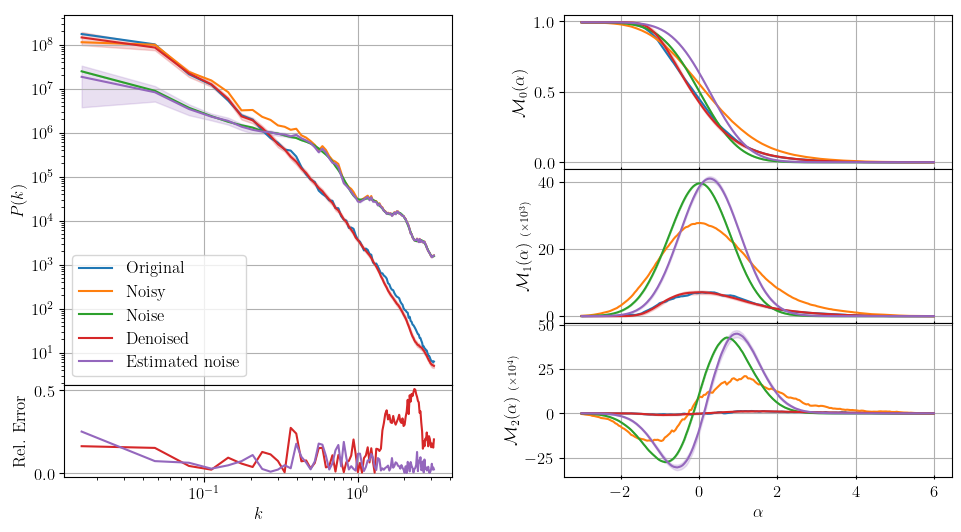

In [146]:
ps_list = [ps_orig, ps_noisy, ps_noise, ps_denoised, ps_estimated_noise]
ps_std_list = [ps_orig_std, ps_noisy_std, ps_noise_std, ps_denoised_std, ps_estimated_noise_std]
ps_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
ps_labels = ['Original', 'Noisy', 'Noise', 'Denoised', 'Estimated noise']

ps_rel_error_list = [np.abs(ps_denoised/ps_orig - 1), np.abs(ps_estimated_noise/ps_noise - 1)]
ps_rel_color = ['C3', 'C4']

mink_list = [mink_orig, mink_noisy, mink_noise, mink_denoised, mink_estimated_noise]
mink_std_list = [mink_orig_std, mink_noisy_std, mink_noise_std, mink_denoised_std, mink_estimated_noise_std]
mink_colors = ['C0', 'C1', 'C2', 'C3', 'C4']


fig, axs = plt.subplots(2, 2, figsize=(10, 6))

subfig = fig.subfigures(1, 2, wspace=0.0)

ax_left = subfig[0].subplots(2, 1, height_ratios=[0.8, 0.2], sharex=True)

for i in range(len(ps_list)):
    ax_left[0].plot(ps_bins, ps_list[i], color=ps_colors[i], label=ps_labels[i])
    ax_left[0].fill_between(ps_bins, ps_list[i]-ps_std_list[i], ps_list[i]+ps_std_list[i], alpha=0.2, color=ps_colors[i])

ax_left[0].set_ylabel(r'$P(k)$')
ax_left[0].set_xscale('log')
ax_left[0].set_yscale('log')
ax_left[0].legend()

for i in range(len(ps_rel_error_list)):
    ax_left[1].plot(ps_bins, ps_rel_error_list[i], color=ps_rel_color[i])

ax_left[1].set_ylabel(r'Rel. Error')
ax_left[1].set_xlabel(r'$k$')

for ax in ax_left:
    ax.grid(True)

ax_right = subfig[1].subplots(3, 1, sharex=True)

pow_factors = [None, 3, 4] # Renormalization of the Minkowski functionals for better visualization

for i in range(3):
    fac = pow_factors[i]
    label_renorm = ''
    if fac is None:
        fac = 1
    else:
        fac = 10 ** fac
        label_renorm = f'  ${{\\scriptstyle (\\times 10^{{{pow_factors[i]}}})}}$'

    for j in range(len(mink_list)):
        ax_right[i].plot(mink_x, mink_list[j][:,i]*fac, color=mink_colors[j])
        ax_right[i].fill_between(mink_x, (mink_list[j][:,i]-mink_std_list[j][:,i])*fac, (mink_list[j][:,i]+mink_std_list[j][:,i])*fac, alpha=0.2, color=mink_colors[j])

    ax_right[i].tick_params(axis="x",direction="inout")

    ax_right[i].set_ylabel(f'$\\mathcal{{M}}_{i}(\\alpha)$' + label_renorm)
ax_right[2].set_xlabel(r'$\alpha$')

for ax in ax_right:
    ax.grid(True)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
if save_fig:
    plt.savefig('figs/stats_sourcesep.pdf', bbox_inches='tight')
plt.show()